In [ ]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.identity import InteractiveBrowserCredential
from azure.ml import MLClient

from azure.ml._constants import AssetTypes
from azure.ml.entities import JobInput

from azure.ml.entities import ImageClassificationSearchSpace, Choice, Uniform, BanditPolicy, JobInput

from azure.ml import automl
# from azure.ml.automl import image_classification

from pprint import pprint

In [ ]:
#Enter details of your AML workspace

# CDLTLL-GPU
# subscription_id = '381b38e9-9840-4719-a5a0-61d9585e1e91' #'<SUBSCRIPTION_ID>'
# resource_group = 'cesardl-automl-eastus2euap-resgrp' # '<RESOURCE_GROUP>'
# workspace = 'cesardl-dist-training-eastus-ws' # '<AML_WORKSPACE_NAME>'

# SAGAR
# subscription_id = "381b38e9-9840-4719-a5a0-61d9585e1e91" #'<SUBSCRIPTION_ID>'
# resource_group = "sasum_centraluseuap_rg" # '<RESOURCE_GROUP>'
# workspace = "sasum-centraluseuap-ws" # '<AML_WORKSPACE_NAME>'

# CDLTLL
# subscription_id = '102a16c3-37d3-48a8-9237-4c9b1e8e80e0' #'<SUBSCRIPTION_ID>'
# resource_group = 'automlpmdemo' # '<RESOURCE_GROUP>'
# workspace = 'cesardl-automl-centraluseuap-ws' # '<AML_WORKSPACE_NAME>'

# JUAMARTI
subscription_id = "381b38e9-9840-4719-a5a0-61d9585e1e91"
resource_group = "juamarti"
workspace = "centraluseuap_phmantri"

In [ ]:
#get a handle to the workspace
credential = InteractiveBrowserCredential() # DefaultAzureCredential()
#credential = DefaultAzureCredential()
ml_client = MLClient(credential, subscription_id, resource_group, workspace)

In [ ]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/image_classification/multilabelFridgeObjects.zip"
data_file = "./multilabelFridgeObjects.zip"
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall()
    print("done")
# delete zip file
os.remove(data_file)

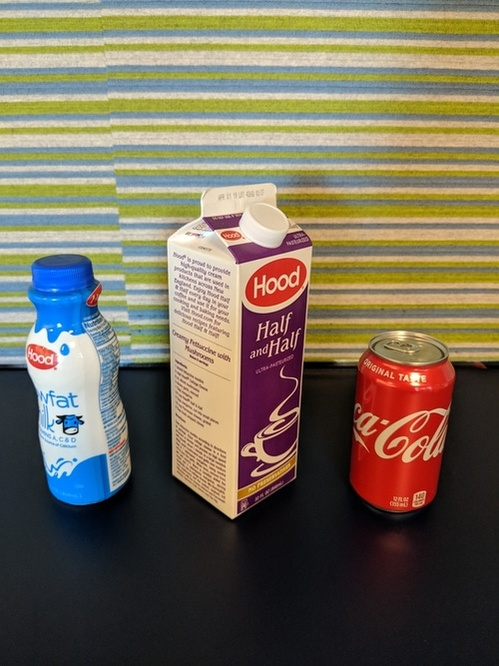

In [1]:
from IPython.display import Image

sample_image = "./multilabelFridgeObjects/images/56.jpg"
Image(filename=sample_image)

### Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

Reference to URI FOLDER data asset example for further details: https://github.com/Azure/azureml-examples/blob/samuel100/data-samples/sdk/assets/data/data.ipynb

In [ ]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ml.entities import Data
from azure.ml._constants import AssetTypes

my_data = Data(
    path="./multilabelFridgeObjects",
    type=AssetTypes.URI_FOLDER,
    description="Fridge-items images multilabel",
    name="fridge-items-images-multilabel",
    version='1'
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)


In [ ]:
# Test access to the registered data asset URI-FOLDER if not uploading files.

uri_folder_data_asset = ml_client.data.get(name="fridge-items-images-multilabel", version="1")

print(uri_folder_data_asset)

In [ ]:
import json
import os

src_images = "./multilabelFridgeObjects/"

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = "./training-mltable-folder/"
validation_mltable_path = "./validation-mltable-folder/"

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(validation_mltable_path, "validation_annotations.jsonl")

# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "label": [],
}

# Path to the labels file.
labelFile = os.path.join(src_images, "labels.csv")

# Read each annotation and convert it to jsonl line
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        with open(labelFile, "r") as labels:
            for i, line in enumerate(labels):
                # Skipping the title line and any empty lines.
                if i == 0 or len(line.strip()) == 0:
                    continue
                line_split = line.strip().split(",")
                if len(line_split) != 2:
                    print("Skipping the invalid line: {}".format(line))
                    continue
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/images/{line_split[0]}"
                json_line["label"] = line_split[1].strip().split(" ")

                if i % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")

In [ ]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = JobInput(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = JobInput(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = JobInput(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = JobInput(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")    

In [ ]:
# Create the AutoML job with the related factory-function.

image_classification_multilabel_job = automl.image_classification_multilabel(
                                        compute = "gpu-cluster",
                                        # name="dpv2-image-classification-job-02",
                                        experiment_name = "dpv2-image-classification-multilabel-experiment",
                                        training_data = my_training_data_input,
                                        validation_data = my_validation_data_input,
                                        target_column_name = "label",
                                        primary_metric = "iou",
                                        tags={"owner": "cesardl"},
                        
                                        # These are temporal properties needed in Private Preview
                                        properties={
                                            "_automl_internal_enable_mltable_quick_profile": True,
                                            "_automl_internal_label": "latest"
                                            # "_automl_internal_scenario": "Vision-Candidate",
                                        }
                                    )
    
# Note, since Image classification sweeping is based on a Sweep/HyperDrive run, max_trials=1
# DEFAULTS:
# image_classification_multilabel_job.set_limits(max_trials=1, max_concurrent_trials=1)

image_classification_multilabel_job.extend_search_space([
    ImageClassificationSearchSpace(
        model_name=Choice(["vitb16r224"]),
        learning_rate=Uniform(0.005, 0.05),
        number_of_epochs=Choice([15, 30]),
        gradient_accumulation_step=Choice([1, 2]),
    ),
    ImageClassificationSearchSpace(
        model_name=Choice(["seresnext"]),
        learning_rate=Uniform(0.005, 0.05),
        # model-specific, valid_resize_size should be larger or equal than valid_crop_size
        validation_resize_size=Choice([288, 320, 352]),
        validation_crop_size=Choice([224, 256]),  # model-specific
        training_crop_size=Choice([224, 256]),  # model-specific
    )
])

image_classification_multilabel_job.set_sweep(max_trials=10, max_concurrent_trials=2, sampling_algorithm="Random",
                             early_termination=BanditPolicy(
                                 evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
                             ))

## 2.2 Run the CommandJob
Using the `MLClient` created earlier, we will now run this CommandJob in the workspace.

In [ ]:
# Submit the AutoML job (CDLTLL: Is it ml_client.create_or_update(regression_job))
returned_job = ml_client.jobs.create_or_update(image_classification_multilabel_job)  # submit the job to the backend

print(f"Created job: {returned_job}")

In [ ]:
# Get a URL for the status of the job
print("Open the following link to observe the AutoML training job/run:")

returned_job.services["Studio"].endpoint

# Next Steps
You can see further examples of other AutoML tasks such as Regression, Image-Object-Detection, NLP-Text-Classification, Time-Series-Forcasting, etc.